# Boston Airbnb

## Section 1: Business Understanding
Using 2016 Airbnb data from the Boston area, I chose to explore metrics to help investors answer potential questions when comparing property locations. The data consists of 3306 Airbnb listings across 18 neighborhoods. The 3 questions I will be lookking into in this analysis are:

#### Question 1: What is the Relationship Between Price and Utilization?
#### Question 2: What are the Top 10 Neighborhoods with the Highest Median Projected Revenue?
#### Question 3: Which Neighborhoods Will Make Me My Money Back the Soonest?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

_ _ _

## Section 2: Data Understanding

### Gather
We start by loading in the data. Data was collected from Kaggle - https://www.kaggle.com/datasets/airbnb/boston

In [2]:
file = 'listings.csv'
df = pd.read_csv(file,index_col=0)
df.shape

(3585, 94)

_ _ _

## Section 3: Data Preperation
### Cleaning Data
For this analysis, we were interested in the relationship between location, price, and utilization; therefore, we select the columns of interest and excluded the other variables in the data set.

In [3]:
#Limit to potential columns of interest
df = df[['name','neighbourhood_cleansed','latitude','longitude','price','availability_30',
         'availability_60','availability_90','availability_365']]

In [4]:
#Note there are no missing values in the columns of interest
df.isnull().mean()

name                      0.0
neighbourhood_cleansed    0.0
latitude                  0.0
longitude                 0.0
price                     0.0
availability_30           0.0
availability_60           0.0
availability_90           0.0
availability_365          0.0
dtype: float64

_ _ _

The 'price' column is an object dtype, yet we need it to be a float dtype for this analysis. Below, I go through the steps on how I converted the column to a float.

In [5]:
#Look at the data types in the dataset
df.dtypes

name                       object
neighbourhood_cleansed     object
latitude                  float64
longitude                 float64
price                      object
availability_30             int64
availability_60             int64
availability_90             int64
availability_365            int64
dtype: object

In [6]:
#notice that price is an object rather than a float
df['price'].head()

id
12147973    $250.00
3075044      $65.00
6976         $65.00
1436513      $75.00
7651065      $79.00
Name: price, dtype: object

The price column is not a float due to the symbols that are being read in the column. For this, we created a simple function to remove the symbols in the cells and covert the output into a float.

In [7]:
#remove the '$'' and the ',' from price
def remove_sign(col):
    """Return the value from a column as a float
    
    Inputs
        col: raw string series from the dataframe
    
    Returns
        col: a float series without the symbols"""
    
    col = col.replace('$','')
    col = col.replace(',','')
    return float(col)

df['price'] = df['price'].apply(remove_sign)
df['price'].head()

id
12147973    250.0
3075044      65.0
6976         65.0
1436513      75.0
7651065      79.0
Name: price, dtype: float64

_ _ _

In this analysis, we were interested in the Utilization Rate of each Airbnb listing. 

**Utilization Rate** == 1 - (Days Available/Days in Time Horizon)

In [8]:
#standardizing availability and covert to Utilization Rate
df['utilization_30'] = df['availability_30'].apply(lambda x: 1 - (x/30))
df['utilization_60'] = df['availability_60'].apply(lambda x: 1 - (x/60))
df['utilization_90'] = df['availability_90'].apply(lambda x: 1 - (x/90))
df['utilization_365'] = df['availability_365'].apply(lambda x: 1 - (x/365))

_ _ _

For this analysis, we decided to filter out neighborhoods with less than 50 listings in the dataset to prevent skewed findings caused by smaller sample sizes.

***Note:*** *changing the minimum count threshold will change the findings in this analysis.*

In [9]:
#how many Airbnbs listings are per neighborhood? Do we need to remove any that are too small of a sample?
df['neighbourhood_cleansed'].value_counts().sort_values()

Leather District             5
Longwood Medical Area        9
Bay Village                 24
Mattapan                    24
Hyde Park                   31
West Roxbury                46
West End                    49
Roslindale                  56
Chinatown                   71
South Boston Waterfront     83
Charlestown                111
Mission Hill               124
North End                  143
Roxbury                    144
East Boston                150
Downtown                   172
South Boston               174
Brighton                   185
Beacon Hill                194
Allston                    260
Dorchester                 269
Fenway                     290
Back Bay                   302
South End                  326
Jamaica Plain              343
Name: neighbourhood_cleansed, dtype: int64

In [10]:
for nb, group in df.groupby('neighbourhood_cleansed'):
    count = len(group)
    df.loc[group.index,'count'] = count

#For this analysis, I chose to only look at neighborhoods with atleast 50 listings.
over_df = df[df['count'] >= 50]

_ _ _

We plotted the prices on a boxplot to see the distribution within the dataset. The outliers are represented by the circles on the graph. 

{'whiskers': [<matplotlib.lines.Line2D at 0x1984cde3d00>,
 'caps': [<matplotlib.lines.Line2D at 0x1984cee2400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1984cde39a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1984cee2ac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1984cee2e20>],
 'means': []}

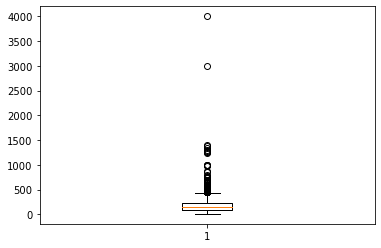

In [11]:
#plot a box and whiskers to see price distributions
prices = over_df['price']
plt.boxplot(prices)

The boxplot shows there are many outliers in the dataset. We decided to remove the top 3% of the prices to remove extreme outliers from the dataset. The remaining outliers will be used to standardize price per night and will be dealt with by using the median statistic in aggregation.

In [12]:
max_price = over_df['price'].max()
max_price

4000.0

In [13]:
#lets get rid of the extreme outliers
max_range = over_df['price'].quantile(.97)
max_range

450.0

In [14]:
over_df.shape

(3397, 14)

After removing the listings in the top 3% of price, we see that the max price drops from 4000 a night to 450. We only lose 93 observations and the neighborhoods maintain a minimum count over 50.

In [15]:
over_df = over_df[over_df['price'] <= max_range]
#only lost around 3% of the data when droppinng extreme outliers
#the other outliers will be dealt with by using median as the statistic of interest
over_df.shape

(3306, 14)

In [16]:
#Check to see if there are any neighborhoods with fewer than 50 listings
over_df['neighbourhood_cleansed'].value_counts().sort_values()

Roslindale                  56
Chinatown                   71
South Boston Waterfront     74
Charlestown                106
Mission Hill               123
Roxbury                    140
North End                  141
East Boston                150
South Boston               166
Downtown                   169
Beacon Hill                183
Brighton                   183
Allston                    257
Dorchester                 269
Fenway                     281
Back Bay                   289
South End                  314
Jamaica Plain              334
Name: neighbourhood_cleansed, dtype: int64

_ _ _

To view the relationship between Price and Utilization, the first step we took was to create a new variable to standatdize price.

**Standard Price** == Listing Price per Night / Max Price per Night in Dataset

In [17]:
#standardize price = Price/Max Price
max_price = over_df['price'].max()
over_df['std_price'] = over_df['price'].apply(lambda col: col/max_price)
over_df['std_price'].head()

id
12147973    0.555556
3075044     0.144444
6976        0.144444
1436513     0.166667
7651065     0.175556
Name: std_price, dtype: float64

_ _ _

We are also interested in the yearly projected revenue for our analysis. 

**Revenue Projection** ==  Price per Night * 365 * Yearly Utilization Rate

In [18]:
#Revenue Projection == (Price * 365) * Yearly Utilization Rate
over_df['revenue_projection'] = (over_df['price']*365) * over_df['utilization_365']

_ _ _


## Neighborhood Analysis

### Visualize
Lets compare neighbourhoods using some metrics from the dataset and the metrics we have created above.

### 1. What is the Relationship Between Price and Utilization?
To address this question, we built a horizontal bar chart to compare the standardized Price per Night and Yeraly Utilization Rate by each neighborhood.

In [19]:
group_df = over_df.groupby('neighbourhood_cleansed')[['std_price','utilization_365']].median().sort_values(by='std_price')

Text(0.5, 1.0, 'What is the Relationship Between Price and Utilization Rate?')

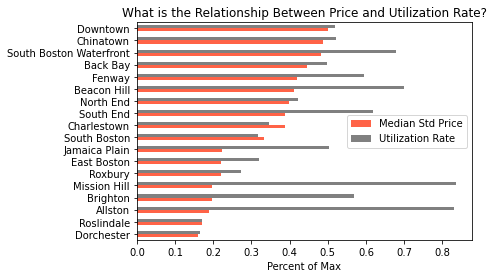

In [20]:
group_df.columns = ['Median Std Price','Utilization Rate']

group_df.plot(kind='barh',color=['tomato','gray'])
plt.xlabel('Percent of Max')
plt.ylabel('')
plt.title('What is the Relationship Between Price and Utilization Rate?')

**Analysis:** When sorting the data by the median standardized price by each neighborhood, we can see there is no clear relationship between the two metrics.

*So what is more important, Price per Night or Utilization?*

_ _ _

### 2. What are the Neighborhoods with the Highest Median Projected Revenue?
We built a horizontal bar chart to compare the top 10 nieghborhoods with the highest median projected revenue. This would give us a better picture of the harmony between the Price per Night and Utilization Rate.

In [21]:
def plot_colors(df,sym,threshold):
    """ Returns color outputs based of the threshold input by the user to emphasis the plots.
    
    Inputs
        df: dataframe
        sym: input either '>' if greater or '<' if less than the threshold
        threshold: top X percente to emphasize in the graph. Pass a decimal
    
    Output
        colors: list of colors to be passed to the plot parameter"""
    
    colors = []

    for i in df:
        if sym == '>':
            if i/df.max() >= threshold:
                colors.append('tomato')
            else:
                colors.append('lightsalmon')
        elif sym == '<':
            if i/df.max() <= threshold:
                colors.append('tomato')
            else:
                colors.append('lightsalmon')
            
    return colors

In [22]:
#get top 10 neighborhoods with highest revenue projections
top_10_rev = over_df.groupby('neighbourhood_cleansed')['revenue_projection'].median()
top_10_rev = top_10_rev.sort_values(ascending=False).iloc[0:10]

Text(0.5, 1.0, 'Top 10 Boston Neighbourhoods with the Highest Project Revenues on Airbnb')

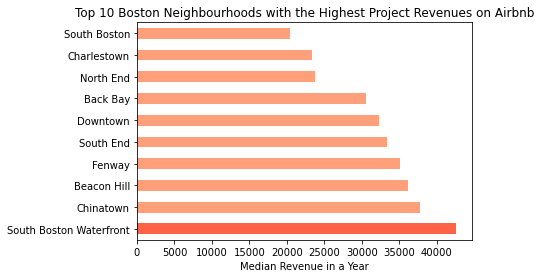

In [23]:
#add specific graph coloring to emphasize the highest projected revenue
colors = plot_colors(top_10_rev,'>',.9)

#Graph Edits
top_10_rev.plot(kind='barh',legend=None,color=colors)
plt.xlabel('Median Revenue in a Year')
plt.ylabel('')
plt.title('Top 10 Boston Neighbourhoods with the Highest Project Revenues on Airbnb')

**Analysis:** When comparing the neighborhoods with this metric, we clearly see that **South Boston Waterfront** provides the highest projected revenue given its high pricing and high utilization rate.

_ _ _

### 3. Which Neighborhoods Will Make Me My Money Back the Soonest?

Not everyone has the luxury of buying million dollar homes, so we explored which neighborhoods in the dataset would offer an ROI in the shortest amount of time.

We used Redfin's **Market Insights tool** to collect the **median house prices** per neighborhood in the dataset.

***Source:*** https://www.redfin.com/

In [24]:
#Median house prices per neighborhood
median_house_prices = {
    'Leather District':979500,
    'Fenway':1064500,
    'Roslindale':699000,
    'Dorchester':690000,
    'West Roxbury':750000,
    'Roxbury':739900,
    'Mattapan':610000,
    'Hyde Park':615000,
    'Bay Village':2878750,
    'East Boston':675000,
    'Brighton':500000,
    'Jamaica Plain':757500,
    'Mission Hill':865000,
    'Allston':539000,
    'South Boston':825000,
    'Longwood Medical Area':1200000,
    'Charlestown':952500,
    'North End':898000,
    'West End':518375,
    'Back Bay':1100000,
    'Downtown':1125000,
    'South End':1100100,
    'Beacon Hill':1200000,
    'Chinatown':1310000,
    'South Boston Waterfront':1134000
    }

We created the Years ROI metric to calculate how many years it would take to pay off the median house price given the median projected revenue by each neighborhood respectively.

***Note:*** *This assumes present dollar value and a straight line revenue growth.*

**Years ROI** == Median House Price / Median Revenue Projection

In [25]:
#use the median house prices to calculate years for ROI
for nb,group in over_df.groupby('neighbourhood_cleansed'):
    try:
        price = median_house_prices[nb] #median price of the house from the dictionary
        median_rev = group['revenue_projection'].median() #calculate the median of revenue projection for the group
        over_df.loc[group.index,'yrs_roi'] = price/median_rev
    except:
        pass

In [26]:
#get the top 10 neighborhoods with the lowest time for ROI
roi_df = over_df.groupby('neighbourhood_cleansed')['yrs_roi'].mean()
top_10_roi = roi_df.sort_values().iloc[0:10]

Text(0.5, 1.0, 'Top 10 Boston Neighbourhoods with the Shortest Time for ROI')

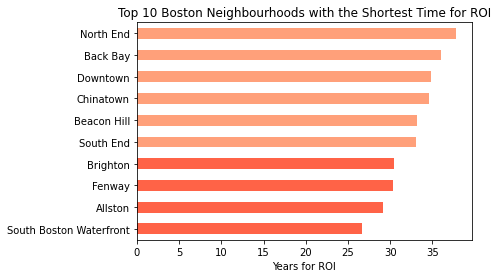

In [27]:
colors = plot_colors(top_10_roi,'<',.85)

top_10_roi.plot(kind='barh',legend=None,color=colors)
plt.xlabel('Years for ROI')
plt.ylabel('')
plt.title('Top 10 Boston Neighbourhoods with the Shortest Time for ROI')

**Analysis:** When comparing the median revenue in a year to the median house prices for each neighborhood respectively, we see how many years it would take to recover all the money invested into the property. This assumes present dollar value and a straight line revenue growth.
The top 4 neighborhoods show us 2 different types of investments.
1. **South Boston Waterfront** and **Fenway** are both neighborhoods with a median home price of **1.13 and 1.06 million**
2. **Allston** and **Brighton** are neighborhoods with median home prices of **539K and 500K**; yet Allston, Fenway, and Brighton are all relatively close in years till ROI.

Depending on the investor, this metric shows how even properties valued at a lower market value an be valuable and payed off in the same amount of time when compared to other, more expensive properties.